In [36]:
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from sensors import *

In [3]:
def err(G, sensors, labels, i):
    preds = flow_prediction_nls(G, {s: labels[s] for s in sensors[:i]})
    return mse(preds, labels)

In [4]:
def corr(G, sensors, labels, i):
    preds = dict2vect(G, flow_prediction_nls(G, {s: labels[s] for s in sensors[:i]}))
    actual = dict2vect(G, labels)
    return np.corrcoef(actual, preds)[1,0]

In [82]:
def plot_results(G, labeled_flows, ratio, ax, title, xlabel, ylabel, legend=False, samples=50):
    k = int(G.number_of_edges() * ratio)
    
    random_sensors = choose_sensors_random(G, k=k)
    rrqr_sensors = al_flows_rrqr(G, ratio)
    rb_sensors = al_flows_rb(G, ratio)
    greedy_sensors = choose_sensors(G, labeled_flows, flow_prediction, mse, lazy=True, cores=8, k=k)
    
    greedy_corr, rand_corr, rrqr_corr, rb_corr = {}, {}, {}, {}

    for j in tqdm(range(samples)):
        i = int(k * j / samples)
        
        greedy_corr[i / G.number_of_edges()] = max(0, corr(G, greedy_sensors, labeled_flows, i))
        rand_corr[i / G.number_of_edges()] = max(0, corr(G, random_sensors, labeled_flows, i))
        rrqr_corr[i / G.number_of_edges()] = max(0, corr(G, rrqr_sensors, labeled_flows, i))
        rb_corr[i / G.number_of_edges()] = max(0, corr(G, rb_sensors, labeled_flows, i))
    
    ax.plot(greedy_corr.keys(), greedy_corr.values(), "b", label="Greedy",
           linewidth=2)
    ax.plot(rand_corr.keys(), rand_corr.values(), "r", label="Random",
           linewidth=2)
    ax.plot(rrqr_corr.keys(), rrqr_corr.values(), "g", label="RRQR",
           linewidth=2)
    ax.plot(rb_corr.keys(), rb_corr.values(), "m", label="RB",
           linewidth=2)
    
    if legend:
        ax.legend(fontsize=14)
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    if xlabel:
        ax.set_xlabel("Fraction of Edges Labeled")
    else:
        ax.set_xticklabels([])
    if ylabel:
        ax.set_ylabel("Correlation")
    else:
        ax.set_yticklabels([])
    ax.grid("on")
    ax.set_title(title)
    return {
        "greedy": greedy_corr,
        "random": rand_corr,
        "rrqr": rrqr_corr,
        "rb": rb_corr
    }

In [83]:
def read_tntp_graph(filename, ax, title, xlabel=True, ylabel=True, legend=False):
    edgelist = pd.read_csv(filename, sep="\t")
    G = nx.from_pandas_edgelist(edgelist, source="From ", target="To ", edge_attr="Volume ",
                           create_using=nx.DiGraph)
    labeled_flows = {(u,v) : d["Volume "] for u,v,d in G.edges(data=True)}
    return plot_results(G, labeled_flows, 1, ax, title, xlabel, ylabel, legend=legend)

  0%|          | 0/914 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

/home/ab141/.conda/envs/sensor/lib/python3.10/site-packages/numpy/lib/function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/ab141/.conda/envs/sensor/lib/python3.10/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


  0%|          | 0/2522 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

/home/ab141/.conda/envs/sensor/lib/python3.10/site-packages/numpy/lib/function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/ab141/.conda/envs/sensor/lib/python3.10/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


  0%|          | 0/2950 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

/home/ab141/.conda/envs/sensor/lib/python3.10/site-packages/numpy/lib/function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/ab141/.conda/envs/sensor/lib/python3.10/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


  0%|          | 0/2836 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

/home/ab141/.conda/envs/sensor/lib/python3.10/site-packages/numpy/lib/function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/ab141/.conda/envs/sensor/lib/python3.10/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


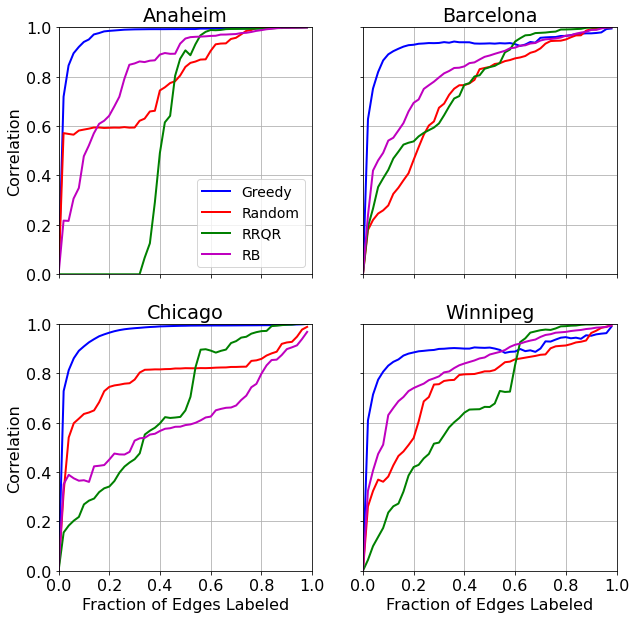

In [84]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

matplotlib.rcParams.update({'font.size': 16})

results = {}
results["Anaheim"] = read_tntp_graph("data/Anaheim/Anaheim_flow.tntp", axes[0][0], "Anaheim", xlabel=False, 
                                     legend=True)
results["Barcelona"] = read_tntp_graph("data/Barcelona/Barcelona_flow.tntp", axes[0][1], "Barcelona", xlabel=False, 
                                     ylabel=False)
results["Chicago"] = read_tntp_graph("data/Chicago-Sketch/ChicagoSketch_flow.tntp", axes[1][0], "Chicago")
results["Winnipeg"] = read_tntp_graph("data/Winnipeg/Winnipeg_flow.tntp", axes[1][1], "Winnipeg", ylabel=False)
plt.savefig("results/flow_correlations.pdf")

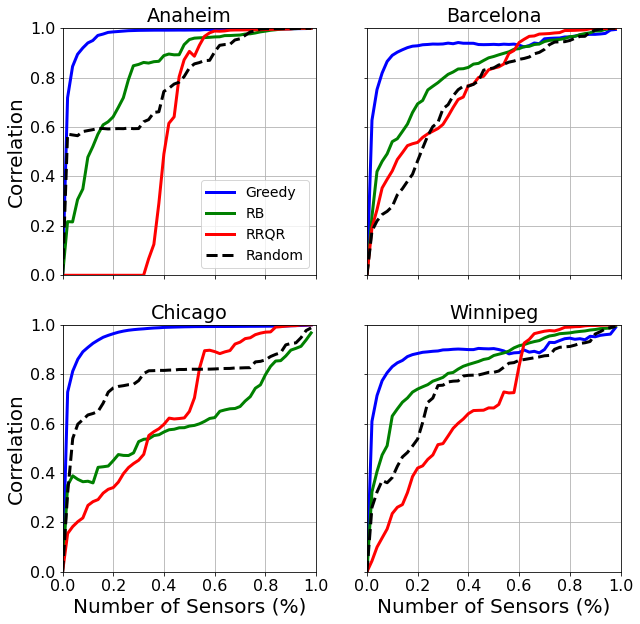

In [109]:
def plot_saved_results(results, ax, title, xlabel=False, ylabel=False, legend=False):
    ax.plot(results["greedy"].keys(), results["greedy"].values(), "b", label="Greedy",
           linewidth=3)
    ax.plot(results["rb"].keys(), results["rb"].values(), "g", label="RB",
           linewidth=3)
    ax.plot(results["rrqr"].keys(), results["rrqr"].values(), "r", label="RRQR",
           linewidth=3)
    ax.plot(results["random"].keys(), results["random"].values(), "black", label="Random",
           linewidth=3, linestyle="dashed")
    
    if legend:
        ax.legend(fontsize=14)
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    if xlabel:
        ax.set_xlabel("Number of Sensors (%)", fontsize=20)
    else:
        ax.set_xticklabels([])
    if ylabel:
        ax.set_ylabel("Correlation", fontsize=20)
    else:
        ax.set_yticklabels([])
    ax.grid("on")
    ax.set_title(title)

fig, ax = plt.subplots(2, 2, figsize=(10, 10))

plot_saved_results(results["Anaheim"], ax[0][0], "Anaheim", ylabel=True, legend=True)
plot_saved_results(results["Barcelona"], ax[0][1], "Barcelona")
plot_saved_results(results["Chicago"], ax[1][0], "Chicago", xlabel=True, ylabel=True)
plot_saved_results(results["Winnipeg"], ax[1][1], "Winnipeg", xlabel=True)
plt.savefig("results/flow_correlations.pdf")

In [7]:
import json

graph = "data/Anaheim/Anaheim_flow.tntp"
data = "data/Anaheim/anaheim_nodes.geojson"

edgelist = pd.read_csv(graph, sep="\t")
G = nx.from_pandas_edgelist(edgelist, source="From ", target="To ", edge_attr="Volume ",
                           create_using=nx.DiGraph)
labeled_flows = {(u,v) : d["Volume "] for u,v,d in G.edges(data=True)}
synthetic = synthetic_flows(G)

synthetic_sensors = choose_sensors(G, synthetic, flow_prediction, mse, k=int(G.number_of_edges() / 10))
greedy_sensors = choose_sensors(G, labeled_flows, flow_prediction, mse, k=int(G.number_of_edges() / 10))

  0%|          | 0/91 [00:00<?, ?it/s]

  0%|          | 0/91 [00:00<?, ?it/s]

In [8]:
with open(data) as f:
    features = json.loads(f.read())["features"]

coords = {}
for feat in features:
    coords[feat["properties"]["id"]] = feat["geometry"]["coordinates"]

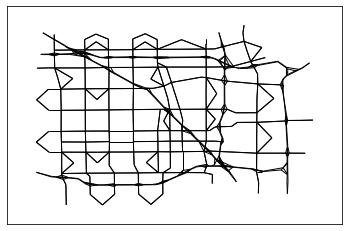

In [23]:
nx.draw_networkx_edges(G, coords, arrows=False)

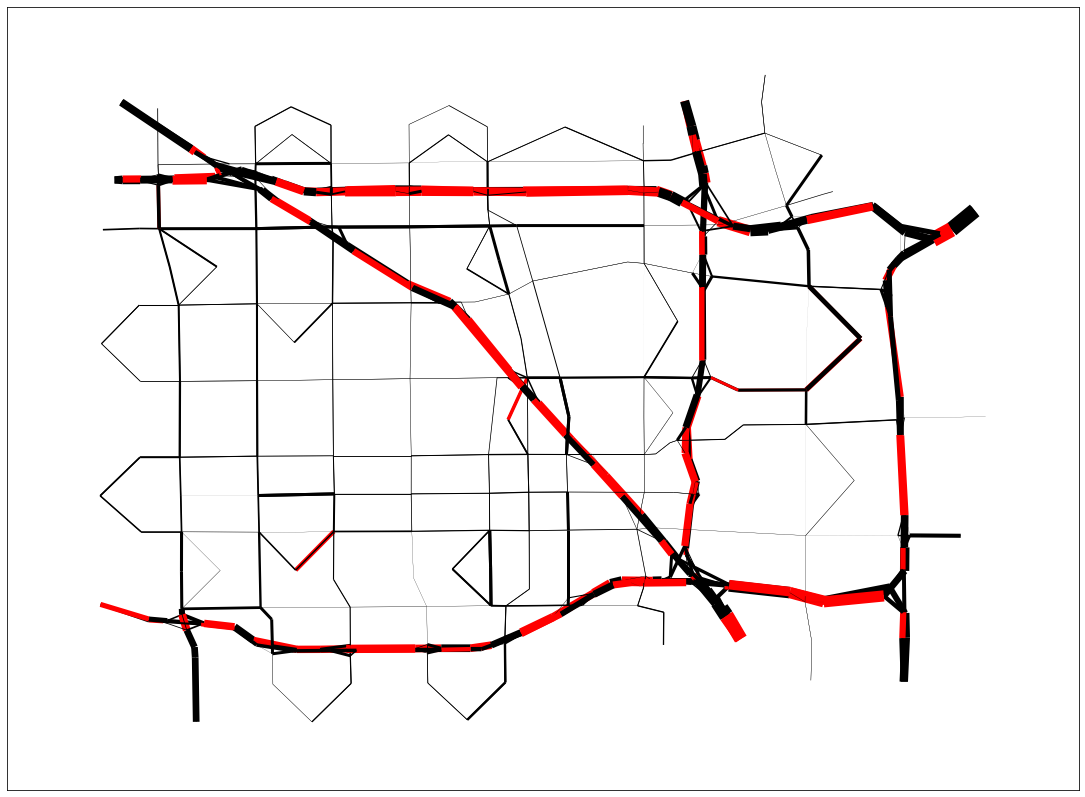

In [102]:
import matplotlib.colors as mcolors

colormap = plt.cm.Reds
flows = [labeled_flows[e] for e in G.edges()]
normalize = mcolors.Normalize(vmin=np.min(flows), vmax=np.max(flows))
s_map = plt.cm.ScalarMappable(norm=normalize, cmap=colormap)

sensor_color = mcolors.to_rgba("green")
edge_color = [sensor_color if e in greedy_sensors else s_map.to_rgba(labeled_flows[e]) for e in G.edges()]

plt.figure(figsize=[3 * x for x in [6.4, 4.8]])
nx.draw_networkx_edges(G, coords, 
        edge_color= ["red" if e in greedy_sensors else "black" for e in G.edges()],
        arrows=False, width=[15 * f / max(flows) if f > 0 else 3 for f in flows])
plt.savefig("Anaheim_sensors.pdf")

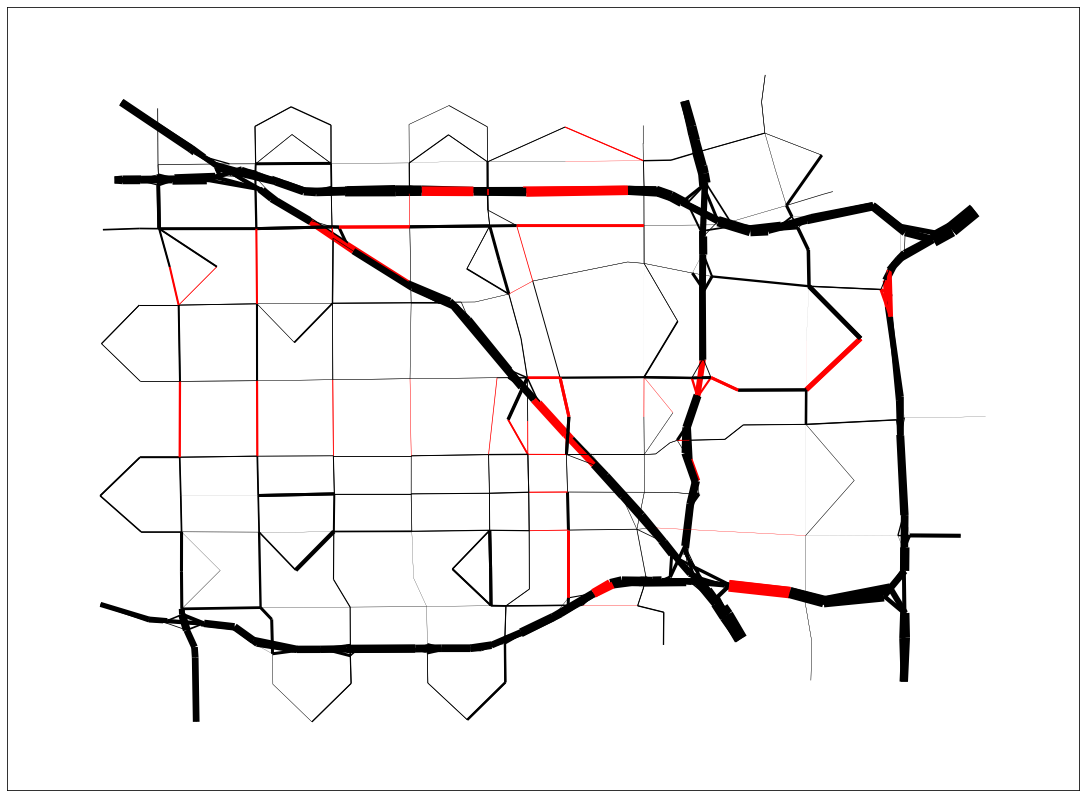

In [65]:
rb_sensors = al_flows_rb(G, .1)

plt.figure(figsize=[3 * x for x in [6.4, 4.8]])
nx.draw_networkx_edges(G, coords, 
        edge_color= ["red" if e in rb_sensors else "black" for e in G.edges()],
        arrows=False, width=[15 * f / max(flows) if f > 0 else 3 for f in flows])
plt.savefig("Anaheim_rb_sensors.pdf")

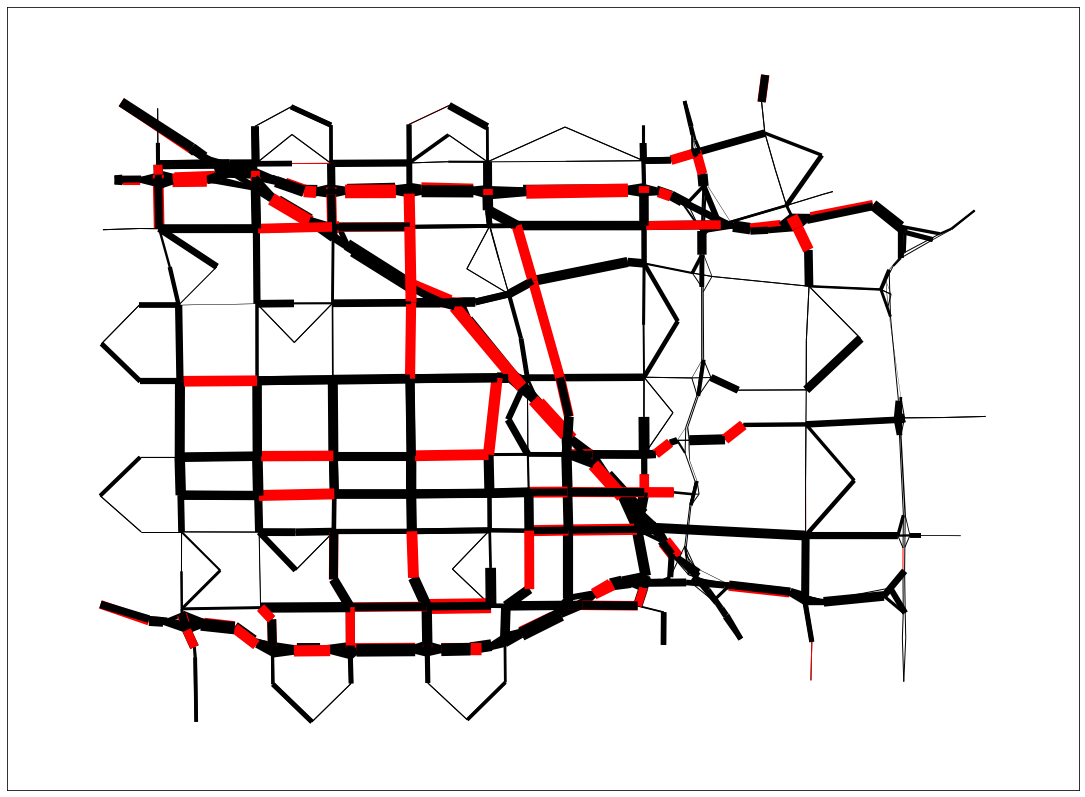

In [62]:
plt.figure(figsize=[3 * x for x in [6.4, 4.8]])
flows = [synthetic[e] for e in G.edges()]
normalize = mcolors.Normalize(vmin=np.min(flows), vmax=np.max(flows))
s_map = plt.cm.ScalarMappable(norm=normalize, cmap=colormap)
nx.draw_networkx_edges(G, coords, 
        edge_color=["red" if e in synthetic_sensors else "black" for e in G.edges()], 
        arrows=False, width=[15 * f / max(flows) if f > 0 else 1 for f in flows])
plt.savefig("Anaheim_synthetic_sensors.pdf")